# $e/\gamma$ ECAL Shower Classification with ML

### Introduction

<img src="./images/cms_overall.png" alt="CMS Overview" width=40% style="float:left"/>

<img src="./images/cms_layout_transverse.png" alt="CMS Transverse Layout" width=55% style="float:right"/>

*Figure*: **[1]** Overview of the CMS detector (*left*) and **[2]** Transverse layout of the CMS detector (*right*)

The Large Hadron Collider (LHC) at CERN smashes protons together at close to the speed of light. Some of the collision energy is turned into mass, creating new particles which are observed in the Compact Muon Solenoid (CMS) particle detector **[1]**. Different layers of the CMS detector **[2]** measure different particles and phenomena produced in the high-energy collision, which are later analyzed to reconstruct a picture of events at the heart of the collision. Electromagnetic calorimeter (ECAL) at the CMS detector measures electrons ($e$) and photons ($\gamma$) from their energy deposits, called "shower", in the calorimeter. 

With the measurements from ECAL, combined with those from the previous layer of the detector, silicon tracker, physicists are able to identify and reconstruct the electrons and photons. However, with the information of ECAL shower only, it is not possible with the "traditional" method to identify the particle as electron or photon. 

In this project, we aim to distinguish electron vs. photon showers using Deep Learning algorithm, with a convolutional neural network (CNN) as a classifier. While the two are nearly indistinguishable in the ECAL, the electron shower is very slightly skewed along the φ direction due to its interaction with the B-field of the CMS solenoid. This effect, however, is very subtle and not easily discernible by eye. Thus, e/γ classification is a very stringent test of how sensitive CNN algorithms are to subtle variations in the data.

### Overview of ECAL

<img src="./images/ECAL_yz.png" alt="ECAL y-z Plane View" width=48% style="float:right"/>

<img src="./images/ECAL_overview.png" alt="ECAL Overview" width=42% style="float:left"/>

The CMS electromagnetic calorimeter (ECAL) is made up of 75,848 homogeneous lead tungstate ($PbWO_{4}$) crystals. When electrons and photons pass through the crystal, it "scintillates" and produces light in proportion to the particle's energy. The photodetectors, glued onto the back of each of the crystals, detect the scintillation light and convert it to an electrical signal that is amplified and sent for analysis. 

The crystals are arranged in a central barrel section with pseudorapidity coverage up to $\eta$ = 1.479, closed by two endcaps extending the coverage up to $\eta$ = 3.0. For extra spatial precision, the ECAL also contains Preshower detectors that sit in front of the endcaps. The cylindrical barrel consists of 61,200 crystals, arranged in a grid of 170 (pseudorapidity, $\eta$) x 360 (azimuthal angle in the transverse plane, $\phi$). Each crystal spans an angular area of 0.0174 x 0.0174. A single crystal is represented in the image data as a single pixel, with the energy deposited in the crystal corresponding to the intensity of that pixel.

In this project, we will use ECAL shower data from the barrel section only. 

### Now, let's work with data!

We will use single electron and single photon particle guns, generated with uniform pT = (15, 100) GeV, |$\eta$| < 1.4, and -π < $\phi$ < π. These are simulated through the full 2017 CMS detector, accounting for the effects of the preceding tracker layers on the e/γ shower. Energy deposits from simulated pileup are overlaid as well. 
1. **Electron** data: *'SingleElectronPt15To100_pythia8_PU2017_MINIAODSIM.**'*
2. **Photon** data: *'SinglePhotonPt15To100_pythia8_PU2017_MINIAODSIM.**'*

In [1]:
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pyarrow as pa
import pyarrow.parquet as pq
import glob

In [2]:
# Import data

# electron data
elec = glob.glob('./data/SingleElectronPt15To100_pythia8_PU2017_MINIAODSIM.parquet.[1-8]')
elec = [pq.ParquetFile(i) for i in elec]

nEntries_elec = [f.num_row_groups for f in elec] # total event number in the electron data files

# photon data
pho = glob.glob('./data/SinglePhotonPt15To100_pythia8_PU2017_MINIAODSIM.parquet.[1-8]')
pho = [pq.ParquetFile(i) for i in pho]

nEntries_pho = [f.num_row_groups for f in pho] # total event number in the photon data files
    
#print(nEntries_elec, nEntries_pho)

#### Sneak peek into the physics variables in the data

In [3]:
n = 0 # event number
pho_id = elec[0].read_row_group(n, columns=['pho_id.list.item']).to_pydict()['pho_id'][0]
pho_p4 = elec[0].read_row_group(n, columns=['pho_p4.list.item']).to_pydict()['pho_p4'][0]
pi0_p4 = elec[0].read_row_group(n, columns=['pi0_p4.list.item']).to_pydict()['pi0_p4'][0]

print('Some of the e/gamma physics variables')
print("\n* Identification-related (a lot of jargons here, so don't worry if you don't understand things here; see the note below)")
print('pho_id: r9 = {}, sieie = {}, phoIso = {}, chgIso = {}, chgIsoWrongVtx = {}, Eraw = {}, phiWidth = {}, etaWidth = {}, scEta = {}, sieip = {}, s4 = {}'.format(pho_id[0], pho_id[1], pho_id[2], pho_id[3], pho_id[4], pho_id[5], pho_id[6], pho_id[7], pho_id[8], pho_id[9], pho_id[10]))
print('\n* Reconstructed particle info')
print('pho_p4: E = {}, pT = {}, eta = {}, phi = {}'.format(pho_p4[0], pho_p4[1], pho_p4[2], pho_p4[3]))
print('\n* Generator-level particle info')
print('pi0_p4: E = {}, pT = {}, eta = {}, phi = {}'.format(pi0_p4[0], pi0_p4[1], pi0_p4[2], pi0_p4[3]))

Some of the e/gamma physics variables

* Identification-related (a lot of jargons here, so don't worry if you don't understand things here; see the note below)
pho_id: r9 = 0.811137855052948, sieie = 0.008787333033978939, phoIso = 0.24755859375, chgIso = 0.0, chgIsoWrongVtx = 1.14208984375, Eraw = 92.4314193725586, phiWidth = 0.01900901272892952, etaWidth = 0.009727902710437775, scEta = -0.9780358076095581, sieip = -5.351574145606719e-06, s4 = 0.821037769317627

* Reconstructed particle info
pho_p4: E = 94.0337142944336, pT = 60.707672119140625, eta = -1.0049859285354614, phi = -1.0580345392227173

* Generator-level particle info
pi0_p4: E = 93.25843048095703, pT = 60.13074493408203, eta = -1.006648063659668, phi = -1.0671675205230713


**Note)** "Identification-related" variables are the standard variables used to characterize e/γ showers at CMS and are used for the construction of traditional *BDT-based classifiers*. While we do not directly use them for classification in this project, they are here for reference. More information about the meaning of these variables can be found in this link: https://twiki.cern.ch/twiki/bin/view/CMSPublic/SWGuideEgammaShowerShape

### 2D ECAL Shower Image (32x32 window) for $e$ and $\gamma$

ECAL system uses its own coordinate (i$\eta$, i$\phi$), based on the ordering of the crystals with respect to some reference. As dataset for classification, we will use 2D images of $e$/$\gamma$ shower constructed from 32 x 32 windows around the energy maximum of the particle shower. Before we feed the data to the classifier, let's plot and look at the shower image for electron events and photon events, respectively. 

In [24]:
# Plotting function
def plot_shower(img, title = '', doColorbar=True):
    fig, ax = plt.subplots()
    ax.imshow(np.zeros_like(img), cmap='hot_r', origin='lower')
    im = ax.imshow(img, cmap='hot_r', origin='lower', norm=LogNorm(vmin = 1e-2, vmax = 1e+2))

    if doColorbar:
        ax.figure.colorbar(im, ax=ax, fraction=0.045, pad=0.05, label='Energy [GeV]')
        plt.text(0.55, 0.8, r'$\mathbf{CMS}\;\mathit{Simulation}$', fontsize=14, transform=plt.gcf().transFigure) # (x,y) for x,y in (0.,1.) of fig dims
    else:
        plt.text(0.48, 0.8, r'$\mathbf{CMS}\;\mathit{Simulation}$', fontsize=14, transform=plt.gcf().transFigure) # (x,y) for x,y in (0.,1.) of fig dims

    # labels
    plt.xlabel(r"$\mathrm{i\phi}$", size=13)
    plt.ylabel(r"$\mathrm{i\eta}$", size=13)
    plt.title(title, fontsize=13)
    plt.show()

#### Plot 2D Image of Electron ECAL Shower for a ***Single Event***

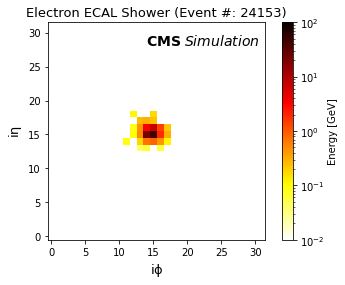

In [25]:
'''
Plot 2D ECAL shower image from ELECTRON data (SINGLE event)
'''

# Randomly pick a single event (event number n) from one of the data above
f = np.random.randint(0,len(elec))                # pick a file
n = np.random.randint(1, high=nEntries_elec[f])   # pick event number

# Get E/gamma shower image from the parquet table and convert it to 32x32 numpy array
X_elec = elec[f].read_row_group(n, 'X').to_pydict()['X']
X_elec = np.array(X_elec).reshape(-1,32)

# Plot in log
plot_shower(X_elec, title='Electron ECAL Shower (Event #: {})'.format(n))

#### Plot 2D Image of Photon ECAL Shower for a ***Single Event***

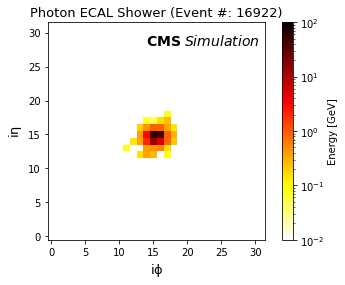

In [26]:
'''
Plot 2D ECAL shower image from PHOTON data (SINGLE event)
'''

# Randomly pick a single event (event number n) from one of the data above
f = np.random.randint(0,len(pho))                 # pick a file
n = np.random.randint(1, high=nEntries_elec[f])   # pick event number

# Get E/gamma shower image from the parquet table and convert it to 32x32 numpy array
X_pho = pho[f].read_row_group(n, 'X').to_pydict()['X']
X_pho = np.array(X_pho).reshape(-1,32)

# Plot in log
plot_shower(X_pho, title='Photon ECAL Shower (Event #: {})'.format(n))

#### Plot 2D Image of Electron ECAL Shower for ***5k Events (Averaged)***

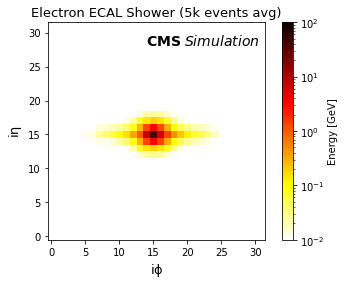

In [27]:
'''
Plot 2D ECAL shower image from ELECTRON data (Log Plot of 5k event AVG sum)
'''

shower = np.zeros([32,32])
for n in range(0,5000):
    # Get E/gamma shower image from the parquet table and convert it to 32x32 numpy array
    X = elec[0].read_row_group(n, 'X')
    X = X.to_pydict()['X']

    X = np.array(X).reshape(-1,32)

    shower += X

# Plot the image in 2d
shower /= 5000.
plot_shower(shower, title='Electron ECAL Shower (5k events avg)'.format(n))

#### Plot 2D Image of Photon ECAL Shower for ***5k Events (Averaged)***

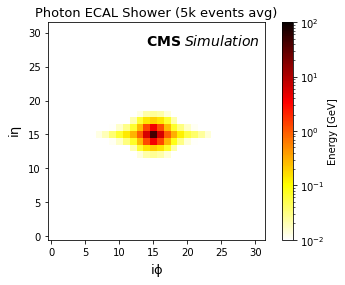

In [28]:
'''
Plot 2D ECAL shower image from PHOTON data (Log Plot of 5k event AVG sum)
'''

shower = np.zeros([32,32])
for n in range(0,5000):
    # Get E/gamma shower image from the parquet table and convert it to 32x32 numpy array
    X = pho[4].read_row_group(n, 'X')
    X = X.to_pydict()['X']

    X = np.array(X).reshape(-1,32)

    shower += X

# Plot the image in 2d
shower /= 5000.
plot_shower(shower, title='Photon ECAL Shower (5k events avg)'.format(n))

*We will classify the particle as a photon or electron directly from its ECAL shower shape, using Deep Learning algorithm.*

## Deep Learning

<img src="./images/ann.png" alt="Neural Network structure" width=500/>

Deep learning, a subset of machine learning, attempts to learn from a training set the mapping of input data to output data, using neural network architecture. 
*Neural networks* are comprised of node layers: an input layer, one or more hidden layers, and an output layer. Each node connects to another and has an associated weight and threshold. If the output of any individual node is above the specified threshold value, that node is activated, sending data to the next layer of the network. Otherwise, no data is passed along to the next layer of the network. 

The *training* of the neural network later facilitates the predictions made by it on a testing data of the same distribution. This mapping is attained by a set of trainable parameters called *weights*, distributed over different layers. The weights are learned by the *back propagation algorithm* whose aim is to minimize a *loss function*. A loss function measures how distant the predictions made by the network are from the actual values. 

Neural networks can be thought of as "universal function approximator".

### Convolutional Neural Network

<img src="./images/cnn.jpg" alt="CNN structure" width=60% style="float:left"/>

<img src="./images/convolution.png" alt="Convolution operation" width=34% style="float:right"/>

*Figure*: **[1]** CNN Architecture (*left*) and **[2]** Convolution Operation (*right*)

Neural networks can be classified into different types, which are used for different purposes. A Convolutional Neural Network (CNN) **[1]** is a Deep Learning algorithm which can take in input image and differentiate one from the other, successfully identifying patterns within an image. CNN architecture is comprised of the following main layers: convolutional layers, pooling layers, and fully connected layer. 

1. Convolutional layer "extracts" features of image, by performing convolution operation **[2]**: it computes the dot product between local regions in the input and the filter ("*kernel*"). Then it slides the kernel over the next local region repeating the same operation, until it goes through the whole image. It has ReLU activation function to make all negative value to zero. 

2. Pooling layer, used between convolutional layers, reduces the spatial volume of image after convolution, in order to avoid computationally expensive cost. 

3. Fully connected layer connects nodes in one layer to those in others to compute the "score" for each category and classify the images. 

In this way, CNN transforms the original image, layer by layer, from the original pixel values to the final class/category scores. 

### Residual Neural Network (ResNet)

<img src="./images/nested.png" alt="Nested function classes" width=55% style="float:left"/>

<img src="./images/resnet.png" alt="Residual Blocks" width=35% style="float:right"/>

*Figure*: **[1]** Network Structure Changing with Adding layers (*left*) and **[2]** Residual Blocks (*right*)

While CNN performs a good fitting to image dataset with the reduction in the number of parameters involved and reusability of weights, the training becomes more difficult as more layers are added. It can have "*vanishing gradient problem*", which is an issue a typical neural network will have as you go "deeper". Moreover, adding layers to an existing network changes the structure of the network: the network is forced to use the new layer, altering the structure. That is, the "function class" gains complexity with more "depth" and does not overlap with the shallower network anymore **[1]**. One way to solve this issue is to add layers in such a way that the network is free to ignore the new layers and can use the structures of the shallower network. 

This solution adds new layers, called *Residual Blocks* **[2]**, with a "skip" connection that allows gradients to flow directly through the network. With an identity mapping around, the new layers then get summed into the shallow network. By reducing complexity, the Residual Neural Network (ResNet) keeps less number of parameters to be trained and can solve the aforementioned issues with "going deep". 

### Let's start training!

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import ConcatDataset,DataLoader,sampler
from sklearn.metrics import roc_curve, auc
from utils import *
import os, time

#### Input data (Electron and Photon Data) and split them into training and validation set

In [5]:
# Input Data

event_data = glob.glob('./data/Single*Pt15To100_pythia8_PU2017_MINIAODSIM.parquet.[1-8]')
#event_data = glob.glob('./data/SingleElectronPt15To100_pythia8_PU2017_MINIAODSIM.parquet.[1-8]')
#event_data += glob.glob('./data/SinglePhotonPt15To100_pythia8_PU2017_MINIAODSIM.parquet.[1-6]')

print(">> Input files:", [ s[13:17]+'.'+s[-1] for s in event_data ])

assert (any('Electron' in d for d in event_data) and any('Photon' in d for d in event_data)), "Must have at least 1 photon + 1 electron file."

>> Input files: ['Elec.1', 'Elec.2', 'Elec.3', 'Elec.4', 'Elec.5', 'Elec.6', 'Elec.7', 'Elec.8', 'Phot.1', 'Phot.2', 'Phot.3', 'Phot.4', 'Phot.5', 'Phot.6', 'Phot.7', 'Phot.8']


In [6]:
# Training dataset - for optimizing net
train_set = ConcatDataset([ParquetDatasetLimited(d) for d in event_data])
idxs = np.random.permutation(len(train_set))
train_frac = 0.7  # fraction of training set to the total dataset; the rest will be used for validation
train_cut = int(train_frac*len(train_set)) 

train_sampler = sampler.SubsetRandomSampler(idxs[:train_cut])
train_loader = DataLoader(dataset=train_set, batch_size=32, num_workers=4, sampler=train_sampler, pin_memory=True)        

In [7]:
# Validation dataset - for evaluating net performance
val_set = ConcatDataset([ParquetDatasetLimited(d) for d in event_data])
val_sampler = sampler.SubsetRandomSampler(idxs[train_cut:])
val_loader = DataLoader(dataset=val_set, batch_size=120, num_workers=4, sampler=val_sampler)

#### Create neural network with Resnet architecture

In [13]:
class ResBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        self.downsample = out_channels//in_channels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=self.downsample, padding=1)
        #self.relu = nn.ReLU(inplace=True)
        self.relu = nn.LeakyReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=self.downsample)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)

        if self.downsample > 1:
            residual = self.shortcut(x)

        out += residual
        out = self.relu(out)

        return out

In [69]:
class ResNet(nn.Module):

    def __init__(self, in_channels, nblocks, fmaps):
        super(ResNet, self).__init__()
        self.fmaps = fmaps
        self.nblocks = nblocks

        self.conv0 = nn.Conv2d(in_channels, fmaps[0], kernel_size=7, stride=1, padding=1)
        self.layer1 = self.block_layers(self.nblocks, [fmaps[0],fmaps[0]])
        self.layer2 = self.block_layers(1, [fmaps[0],fmaps[1]])
        self.layer3 = self.block_layers(self.nblocks, [fmaps[1],fmaps[1]])
        self.fc = nn.Linear(fmaps[1], 1)
        
    def block_layers(self, nblocks, fmaps):
        layers = []
        for _ in range(nblocks):
            layers.append(ResBlock(fmaps[0], fmaps[1]))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv0(x)
        x = F.leaky_relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = F.max_pool2d(x, kernel_size=x.size()[2:])
        x = x.view(x.size()[0], self.fmaps[1])
        x = self.fc(x)
        
        return x

#### Set training parameters and create model

In [11]:
# Training parameters
lr_init = 1.5e-4
resblocks = 3
epochs = 20

In [12]:
# Create model with torch_resnet_single structure
resnet = ResNet(1, resblocks, [16, 32])

os.environ["CUDA_VISIBLE_DEVICES"] = str(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet.to(device)

optimizer = optim.Adam(resnet.parameters(), lr=lr_init)
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20], gamma=0.5)

#### Model Summary

In [15]:
# See summary of the net
print(resnet)

ResNet(
  (conv0): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
  (layer1): Sequential(
    (0): ResBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): LeakyReLU(negative_slope=0.01, inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): ResBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): LeakyReLU(negative_slope=0.01, inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    )
    (2): ResBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): LeakyReLU(negative_slope=0.01, inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Conv2d

In [178]:
# See summary of the net (cont'd) with output shape after each layer and the number of parameters
print(summary(resnet, (1,32,32)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 28, 28]          800
├─Sequential: 1-2                        [-1, 16, 14, 14]          --
|    └─ResBlock: 2-1                     [-1, 16, 14, 14]          --
|    |    └─Conv2d: 3-1                  [-1, 16, 14, 14]          2,320
|    |    └─LeakyReLU: 3-2               [-1, 16, 14, 14]          --
|    |    └─Conv2d: 3-3                  [-1, 16, 14, 14]          2,320
|    |    └─LeakyReLU: 3-4               [-1, 16, 14, 14]          --
|    └─ResBlock: 2-2                     [-1, 16, 14, 14]          --
|    |    └─Conv2d: 3-5                  [-1, 16, 14, 14]          2,320
|    |    └─LeakyReLU: 3-6               [-1, 16, 14, 14]          --
|    |    └─Conv2d: 3-7                  [-1, 16, 14, 14]          2,320
|    |    └─LeakyReLU: 3-8               [-1, 16, 14, 14]          --
|    └─ResBlock: 2-3                     [-1, 16, 14, 14]          --
| 

#### Validation function

In [18]:
# Function to validate after training phase
val_loss, val_acc = [], []

def do_eval(resnet, val_loader, roc_auc_best, epoch):
    loss_, acc_ = 0., 0.
    y_pred_, y_truth_, pt_ = [], [], []
    now = time.time()
    for i, data in enumerate(val_loader):
        X, y, pt = data['X'].to(device), data['m'].to(device), data['pt'].to(device) # electron/photon id stored in 'm' key
        logits = resnet(X)
        y = y.type_as(logits) # needs to be same type as logits for next line
        loss_ += F.binary_cross_entropy_with_logits(logits, y).item()
        pred = logits.ge(0.).byte()
        acc_ += pred.eq(y.byte()).float().mean().item()
        y_pred = torch.sigmoid(logits) # not used as an activation fn here; it's to map the logits to the interval [0, 1].
        # Store batch metrics:
        y_pred_.append(y_pred.tolist())
        y_truth_.append(y.tolist())
        pt_.append(pt.tolist())

    now = time.time() - now
    y_pred_ = np.concatenate(y_pred_)
    y_truth_ = np.concatenate(y_truth_)
    pt_ = np.concatenate(pt_)
    s = '\n%d: Val time:%.2fs in %d steps'%(epoch, now, len(val_loader))
    print(s)
    s = '%d: Val loss:%.4f, acc:%.4f'%(epoch, loss_/len(val_loader), acc_/len(val_loader))
    print(s)

    val_loss.append(loss_/len(val_loader))
    val_acc.append(acc_/len(val_loader))
    print('Epoch: {}, Validation loss: {:.4f}, Validation accuracy: {:.4f}'.format(epoch, val_loss[epoch-1], val_acc[epoch-1]))
    
    fpr, tpr, _ = roc_curve(y_truth_, y_pred_)
    roc_auc = auc(fpr, tpr)
    s = "VAL ROC AUC: %.4f"%(roc_auc)
    print(s)

    if roc_auc > roc_auc_best:
        roc_auc_best = roc_auc
    
    return roc_auc_best

#### Run training and validation

In [13]:
# MAIN #
print_step = 1000
roc_auc_best = 0.5
print(">> Training <<<<<<<<")

# training loss and accuracy
train_loss, train_acc = [], []

# training loop
for e in range(epochs):

    epoch = e+1
    s = '\n>> Epoch %d <<<<<<<<'%(epoch)
    print(s)
    
    # Run training
    resnet.train()
    now = time.time()
    running_loss, running_acc = 0, 0
    
    for i, data in enumerate(train_loader):
        X, y = data['X'].to(device), data['m'].to(device)
        optimizer.zero_grad()
        logits = resnet(X)
        y = y.type_as(logits) #same type for next line
        loss = F.binary_cross_entropy_with_logits(logits, y).to(device)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        pred = logits.ge(0.).byte()
        acc = pred.eq(y.byte()).float().mean()
        running_acc += acc.item()

        if i % print_step == 0:
            pred = logits.ge(0.).byte()
            acc = pred.eq(y.byte()).float().mean()
            s = '%d: Train loss:%.4f, acc:%.4f'%(epoch, loss.item(), acc.item())
            print(s)
            
    now = time.time() - now
    s = '%d: Train time:%.2fs in %d steps'%(epoch, now, len(train_loader))
    print(s)

    train_loss.append(running_loss/len(train_loader))
    train_acc.append(running_acc/len(train_loader))
    print('Epoch: {}, Train loss: {:.4f}, Train accuracy: {:.4f}'.format(epoch, train_loss[epoch-1], train_acc[epoch-1]))

    # Run Validation
    resnet.eval()
    roc_auc_best = do_eval(resnet, val_loader, roc_auc_best, epoch)
    lr_scheduler.step()

>> Training <<<<<<<<

>> Epoch 1 <<<<<<<<
1: Train loss:0.6768, acc:0.6875
1: Train loss:0.7296, acc:0.5000
1: Train loss:0.5381, acc:0.6875
1: Train loss:0.5387, acc:0.6562
1: Train loss:0.5164, acc:0.7500
1: Train loss:0.4767, acc:0.7500
1: Train loss:0.4363, acc:0.7812
1: Train loss:0.5646, acc:0.7500
1: Train loss:0.5936, acc:0.7188
1: Train loss:0.5952, acc:0.6875
1: Train loss:0.6231, acc:0.6875
1: Train loss:0.6270, acc:0.6875
1: Train loss:0.4570, acc:0.7500
1: Train loss:0.4990, acc:0.8438
1: Train loss:0.5967, acc:0.6875
1: Train loss:0.6159, acc:0.6250
1: Train loss:0.5298, acc:0.7188
1: Train loss:0.4073, acc:0.8125
1: Train loss:0.5748, acc:0.7500
1: Train loss:0.5861, acc:0.5938
1: Train loss:0.4440, acc:0.7812
1: Train loss:0.6537, acc:0.6562
1: Train time:184.31s in 21216 steps
Epoch: 1, Train loss: 0.5812, Train accuracy: 0.6877

1: Val time:54.15s in 2425 steps
1: Val loss:0.5669, acc:0.7084
Epoch: 1, Validation loss: 0.5669, Validation accuracy: 0.7084
VAL ROC AUC: 0

9: Train loss:0.5138, acc:0.7812
9: Train loss:0.5140, acc:0.7188
9: Train loss:0.4434, acc:0.8750
9: Train loss:0.4487, acc:0.8750
9: Train loss:0.8685, acc:0.5312
9: Train loss:0.4976, acc:0.7188
9: Train loss:0.6049, acc:0.7500
9: Train loss:0.4716, acc:0.6875
9: Train loss:0.5048, acc:0.7500
9: Train loss:0.5281, acc:0.7500
9: Train loss:0.4444, acc:0.7812
9: Train loss:0.5231, acc:0.7500
9: Train loss:0.5003, acc:0.7812
9: Train time:186.91s in 21216 steps
Epoch: 9, Train loss: 0.5340, Train accuracy: 0.7280

9: Val time:54.31s in 2425 steps
9: Val loss:0.5319, acc:0.7282
Epoch: 9, Validation loss: 0.5319, Validation accuracy: 0.7282
VAL ROC AUC: 0.7854

>> Epoch 10 <<<<<<<<
10: Train loss:0.8459, acc:0.5312
10: Train loss:0.5028, acc:0.8125
10: Train loss:0.7221, acc:0.5000
10: Train loss:0.6236, acc:0.6562
10: Train loss:0.4281, acc:0.8125
10: Train loss:0.3953, acc:0.8125
10: Train loss:0.4984, acc:0.8125
10: Train loss:0.4745, acc:0.8125
10: Train loss:0.4596, acc:0.6875
10: T

17: Train loss:0.5995, acc:0.6875
17: Train loss:0.5878, acc:0.6875
17: Train loss:0.6021, acc:0.6250
17: Train loss:0.5226, acc:0.7812
17: Train loss:0.5025, acc:0.7188
17: Train loss:0.6078, acc:0.6562
17: Train loss:0.4561, acc:0.8125
17: Train loss:0.5284, acc:0.7500
17: Train loss:0.5883, acc:0.6562
17: Train time:186.83s in 21216 steps
Epoch: 17, Train loss: 0.5208, Train accuracy: 0.7391

17: Val time:54.37s in 2425 steps
17: Val loss:0.5289, acc:0.7311
Epoch: 17, Validation loss: 0.5289, Validation accuracy: 0.7311
VAL ROC AUC: 0.7896

>> Epoch 18 <<<<<<<<
18: Train loss:0.4966, acc:0.7188
18: Train loss:0.5935, acc:0.6562
18: Train loss:0.5658, acc:0.7188
18: Train loss:0.3965, acc:0.7812
18: Train loss:0.4862, acc:0.7188
18: Train loss:0.4469, acc:0.7812
18: Train loss:0.5793, acc:0.7188
18: Train loss:0.4197, acc:0.8438
18: Train loss:0.5635, acc:0.6250
18: Train loss:0.6838, acc:0.7188
18: Train loss:0.5616, acc:0.7188
18: Train loss:0.5455, acc:0.5938
18: Train loss:0.5518

ROC AUC: 0.7905


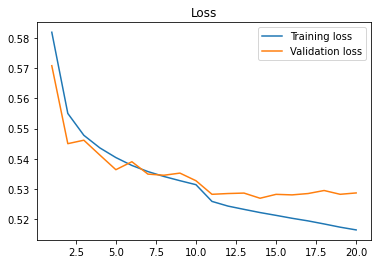

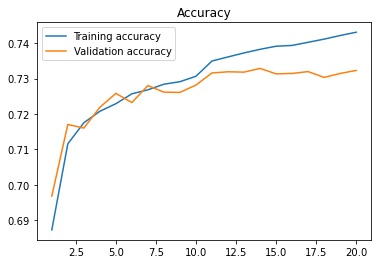

In [95]:
print("ROC AUC: {:.4f}".format(roc_auc_best))

# Plot loss and accuracy curve
plt.plot(list(range(1,epoch+1)), train_loss, label='Training loss')
plt.plot(list(range(1,epoch+1)), val_loss, label='Validation loss')
plt.legend()
plt.title("Loss")
#plt.savefig('loss.png')
plt.show()

plt.plot(list(range(1,epoch+1)), train_acc, label='Training accuracy')
plt.plot(list(range(1,epoch+1)), val_acc, label='Validation accuracy')
plt.legend()
plt.title("Accuracy")
#plt.savefig('accuracy.png')
plt.show()

### Takeaways

With Residual Neural Network, we classified $e$/$\gamma$ from ECAL shower image data. 

You can further try the following with this notebook:
* Take a closer look at the data: plot other physics variables inside the data other than the shower image.
* Play with the parameters for training and check the performance: change initial learning rate, number of epochs, batch size, activation function, number of residual blocks, etc.
* Try different architecture of neural network.